In [1]:
from sklearn.datasets import load_iris
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
data = load_iris()

In [2]:
x=data["data"]
y=data["target"]
df=pd.DataFrame(x)
df["target"]=y

# Simple Kmeans Clustering

we define a function called dist that calculates the euclidean distance between 2 points

In [3]:
def dist(a, b):

    return np.sqrt(np.sum((a - b)**2, axis=1))

We define a function called "initail_centroid" that initializes n random points as cluster centroid between the data points.

In [4]:
def initial_centroid(x,n_cluster):
    x_min=np.min(x, axis=0)
    x_max=np.max(x, axis=0)
    cents = [np.random.uniform(x_min, x_max) for _ in range(n_cluster)]
    return cents

we define a function called "assign_data_point". for each datapoint, it calcutes the distance between each data point with all cluster centroids and assigns it to the cluster with minimum distance

In [5]:
def assign_data_point(x_points,centroids):
    n_cluster=len(centroids)
    sorted_points = [[] for _ in range(n_cluster)]
    for x in x_points:
        dists = dist(x, centroids)

        
        centroid_idx = np.argmin(dists)

        sorted_points[centroid_idx].append(x)
    return sorted_points

Now that we’ve assigned the whole training dataset to their closest centroids, we can update the location of the centroids and finish the iteration.

we define a function called "update_centroid". The centroid of each cluster is the mean of members of that cluster. if a cluster is empty, we do not change its centroid

In [6]:
def update_centroid(sorted_points,prev_cents):
    new_cents=[np.mean(cluster, axis=0) for cluster in sorted_points]
    for i, cent in enumerate(new_cents):
        if np.isnan(cent).any():  # Catch any np.nans, resulting from a centroid having no points
            new_cents[i] = prev_cents[i]
    return new_cents


we define a function called "inter_cluster_dist" that uses the average linkage distance as an inter-cluster distance:

average linkage distance is calculated as below:

$\Delta(C)=\dfrac{1}{N_C *(N_C -1)}\displaystyle\sum_{i,j} d(a_i,a_j)$

$N_C$: number of cluster C members
 $a_i, a_j  \in C$

In [7]:
def inter_cluster_dist(x_points):
    n=len(x_points)
    if n==1 or n==0:
        return 0
    else:
        n_pair=n*(n-1)
        sum=0
        for x in x_points:
            d=dist(x,x_points)
            sum+=d.sum()
        ave=sum/n_pair
        return ave
    



we define a function called "intra_cluster_dist" that uses the average linkage distance as an intra-cluster distance between two clusters:

average linkage distance between two clusters is calculated as below:

$\Delta(C_a , C_b)=\dfrac{1}{N_{C_a}*N_{C_b}}\displaystyle\sum_{i} {\sum_{j}}d(a_i,b_j)$

$N_{C_a},  N_{C_b}$: number of cluster $C_a$, $C_b$ members

 $a_i, b_j  \in C_a , C_b$

In [8]:
def intra_cluster_dist(a_points,b_points):
    n_a=len(a_points)
    n_b=len(b_points)
    if n_a==0 or n_b==0:
        return 0
    else:
        n_pair=n_a*n_b
        sum=0
        for a in a_points:
            d=dist(a,b_points)
            sum+=d.sum()
        ave=sum/n_pair
        return ave

we define a function called "all_inter_cluster_dist" that sums all the inter-cluster distances:

if we hva $k$ clusters, we determine $Inner_{distance}$ as below:

$Inner_{distance}=\sum_{i=0}^{k-1} \Delta(C_i)$

$S=\{C_0,C_1,...,C_{k-1}\}$: cluster set

$\Delta(C_i)$ was determined previously

In [9]:
def all_inter_cluster_dist(sorted_points):
    n_cluster=len(sorted_points)
    sum_ave=0
    for i in range(n_cluster):
        cluster=np.array(sorted_points[i])
        # print(cluster.shape)
        inter_dist=inter_cluster_dist(cluster)
        sum_ave+=inter_dist
    return sum_ave

we define a function called "all_intra_cluster_dist" that sums all the intra-cluster distances:

if we hva $k$ cluster, we determine $Inner_{distance}$ as below:

$Outer_{distance}=\sum_{i\neq j} \Delta(C_i,C_j)$

$S=\{C_0,C_1,...,C_{k-1}\}$: cluster set

$\Delta(C_i,C_j)$ was determined previously

In [10]:
def all_intra_cluster_dist(sorted_points):
    n_cluster=len(sorted_points)
    n_pair=(n_cluster*(n_cluster-1))/2
    sum_ave=0
    for i in range(n_cluster):
        for j in range(n_cluster):
            if i!=j:
                a=np.array(sorted_points[i])
                b=np.array(sorted_points[j])
                dist=intra_cluster_dist(a,b)
                sum_ave+=dist
    return sum_ave

        

we defince a cost function using the formula below:

$cost=\frac{Inner_{distance}}{Outer_{distance}}$

$Inner_{distance}$ and $outer_{distance}$ were determined previously

In [11]:
def cost(sorted_points):
    return all_inter_cluster_dist(sorted_points)/all_intra_cluster_dist(sorted_points)

we define ratio function using the formula below:

$ratio=\frac{Outer_{distance}}{Outer_{distance}+Inner_{distance}}$

In [12]:
def ratio(sorted_points):
    
    a=all_inter_cluster_dist(sorted_points)
    b=all_intra_cluster_dist(sorted_points)
    r=b/(a+b)
    return r

As said in the problem, the goal of kmeans clustering is to minimize the summation of distance of each datapoint and its cluster centroid, so we define a function called "k_means_cost_func" that calculates this obgective function:
$J=\sum_{j=0}^{k-1}\sum_{i=0}^{m-1} a_{ij} d(x_i,\mu_j)$

$n:$ number of data points

$k:$ number of clusters

$\mu_j:$ centroid of cluster $C_j$

if $x_i \in C_j: a_{ij}=1$

else: $a_{ij}=0$

In [13]:
def k_means_cost_func(sorted_points,cents):
    n_cluster=len(cents)
    dist_all=0
    for i in range(n_cluster):
        center=cents[i]
        cluster_points=sorted_points[i]
        if cluster_points:
            cluster_points=np.array(cluster_points)
            d=dist(center,cluster_points)
            dist_all+=np.sum(d)
    return dist_all


we define a function called "k_means" that executes the k-means algorithm. we update the algorithm until we reach the maximum number of iterations. each time we claculate Ratio and Cost Function

In [14]:
def k_means(n_cluster,x,max_iter):
    prev_cents = None
    # iter = 0
    cents=initial_centroid(x,n_cluster)
    all_cost=[]
    all_ratio=[]
    all_kmean_cost=[]
    # while np.not_equal(cents, prev_cents).any() and iter < max_iter:
    for iter in range(max_iter):
        sorted_points= assign_data_point(x,cents)
        prev_cents=cents
        cents=update_centroid(sorted_points,prev_cents)
        all_cost.append(cost(sorted_points))
        all_ratio.append(ratio(sorted_points))
        all_kmean_cost.append(k_means_cost_func(sorted_points,cents))
        # iter+=1
    return sorted_points,all_cost,all_ratio,all_kmean_cost,cents

**A)**

In [ ]:
np.random.seed(10)
all_n_cluster=[5,10,20]
max_iter=20
all_cost=[]
all_ratio=[]
all_knn_cost=[]

for n_cluster in all_n_cluster:
    _,j,r,k,_=k_means(n_cluster,x,max_iter)
    
    all_cost.append(j)
    all_ratio.append(r)
    all_knn_cost.append(k)


Text(0.5, 0.98, 'Cost function (Inter-cluster distance/Intra-cluster distance) in each iteration')

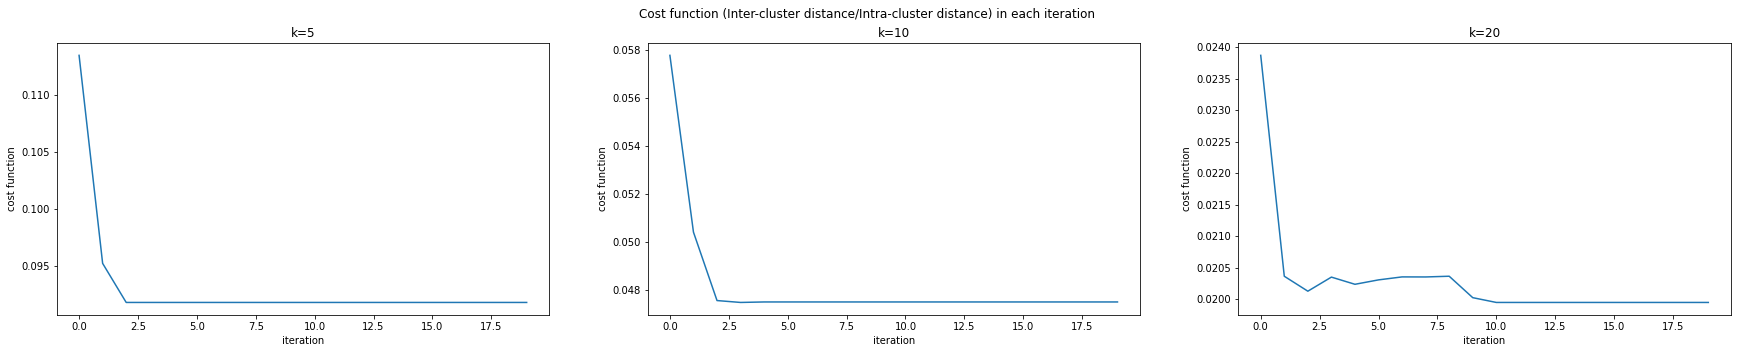

In [ ]:

fig, axs = plt.subplots(1, 3,figsize=(30, 5))
# fig.size(18, 10)
n_iter=np.arange(max_iter)
for i in range(len(all_n_cluster)):
    axs[i].plot(n_iter, all_cost[i])
    axs[i].set_title('k='+str(all_n_cluster[i]))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('cost function')
    # axs[i].set_ylim([0.05,0.3])
fig.suptitle('Cost function (Inter-cluster distance/Intra-cluster distance) in each iteration')

As we can see for each k, the cost function decreases in each iteration untill the best clusters are found and the clusters do not change any more and the cost function remains on a fixed value. we can also see that when the number of clusters increases, the cost function decreases, becouse by increasing the number of clusters, the average distance between two data points within a cluster decreases and the average distance between two data points in different clusters increases

Text(0.5, 0.98, 'Original knn Cost function in each iteration')

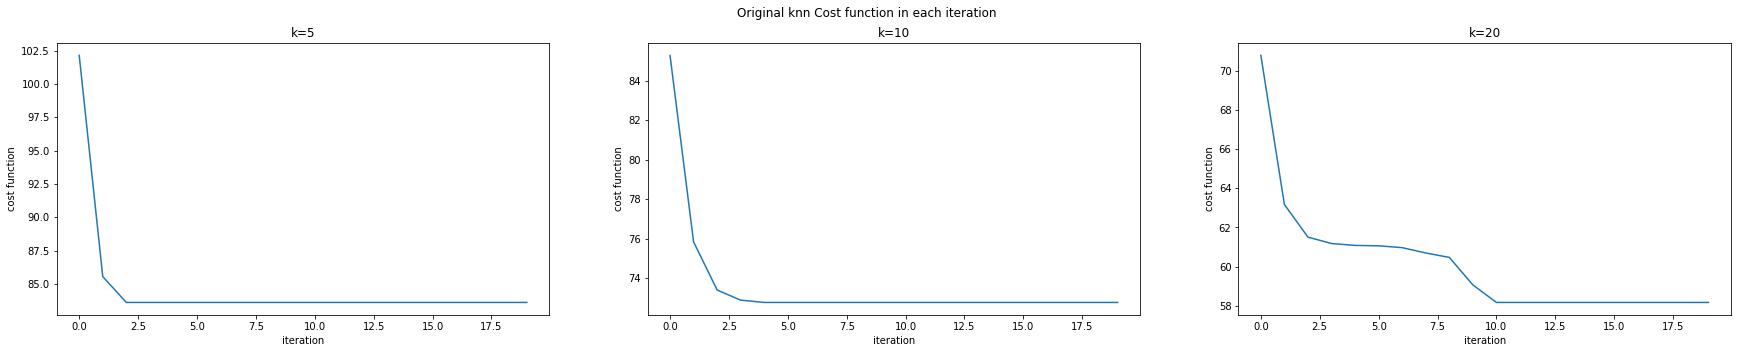

In [ ]:
fig, axs = plt.subplots(1, 3,figsize=(30, 5))
# fig.size(18, 10)
n_iter=np.arange(max_iter)
for i in range(len(all_n_cluster)):
    axs[i].plot(n_iter, all_knn_cost[i])
    axs[i].set_title('k='+str(all_n_cluster[i]))
    axs[i].set_xlabel('iteration')
    axs[i].set_ylabel('cost function')
    # axs[i].set_ylim([0.05,0.3])
fig.suptitle('Original knn Cost function in each iteration')

We can see that the original kmeans cost function  also decreases at each iteration untill it reaches the optimum value. we can also see that by increasing number of clusters, the original kmeans cost function decreases, becous the by increasing the number of clusters, the distance between data points and their cluster centroid decreases.

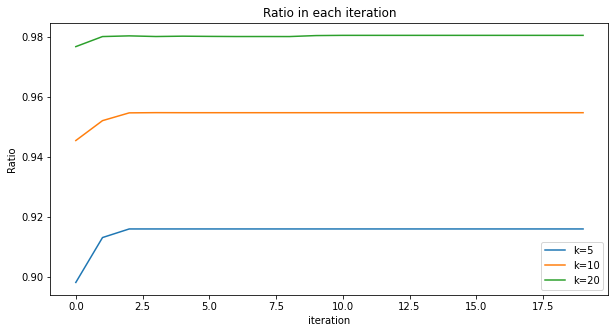

In [ ]:
fig= plt.figure(figsize=(10, 5))
# fig.size(18, 10)
n_iter=np.arange(max_iter)
for i in range(len(all_n_cluster)):
    plt.plot(n_iter, all_ratio[i],label='k='+str(all_n_cluster[i]))

plt.xlabel('iteration')
plt.ylabel('Ratio')
plt.legend()
plt.title('Ratio in each iteration')
plt.show()

As said before, at each iteration, $Inner_{distance}$ decreases and $Outer_{distance}$ increases. So for each k number of clusters, ratio increases at each iteration and converges to 1(We can see that the ratio values are near 1). 

we can also see that by increasing the number of clusters (k), ratio increases, becouse by increasing k, number of cluster combinations used for calcualting $Outer_{distance}$ increases in $O(k^2) $ order but the number of single clusters used for calculating $Inner_{distance}$  increases in $O(k)$ oreder, also for each cluster, the inter-cluster distance decreases as k grows wheras for each 2 different clustes, their intra-cluster distance increase as k grows.Therefore, as k increase,$Inner_{distance}$ decreases and $Outer_{distance}$ increases so ratio also increase.

Since k=20 has the biggest ratio, we guess k=20 is the best number of clusters, but we can not be sure becouse the difference between the ratio values are small. we need to find a k that the difference between ratio(k-1) and ratio(k) is much bigger than the difference between ratio(k) and ratio(k+1). so we need to plot ratio based on number of clusters instead of iterations

**B)**

since the initial cluster centroids effects the final clusters, and are chosen randomly, we repeat the algorithm multiple times and calculate the mean and variance of the results(cost functions and the ratio) to have more stable results

In [16]:
def mean_var_cost(n_alg_iter,n_cluster,max_iter,x):
    costs=[]
    ratios=[]
    cost_knns=[]
    for i in range(n_alg_iter):
         np.random.seed(i)
         _,j,r,k,_=k_means(n_cluster,x,max_iter)
         costs.append(j[-1])
         ratios.append(r[-1])
         cost_knns.append(k[-1])
    
    costs=np.array(costs)
    ratios=np.array(ratios)
    cost_knns=np.array(cost_knns)

    cost_mean=np.mean(costs)
    ratio_mean=np.mean(ratios)
    cost_knn_mean=np.mean(cost_knns)

    cost_var=np.var(costs)
    ratio_var=np.var(ratios)
    cost_knn_var=np.var(cost_knns)

    return cost_mean, ratio_mean, cost_knn_mean, cost_var, ratio_var, cost_knn_var


In [ ]:
n_alg_iter=50
all_n_cluster=[2,5,6,10,13,16,18,20,23,25]
max_iter=20
cost_means=[]
cost_vars=[]
ratio_means=[]
ratio_vars=[]
cost_k_means=[]
cost_k_vars=[]
for n_cluster in all_n_cluster:
    cost_mean, ratio_mean, cost_knn_mean, cost_var, ratio_var, cost_knn_var=mean_var_cost(n_alg_iter,n_cluster,max_iter,x)
    cost_means.append(cost_mean)
    cost_vars.append(cost_var)

    ratio_means.append(ratio_mean)
    ratio_vars.append(ratio_var)

    cost_k_means.append(cost_knn_mean)
    cost_k_vars.append(cost_knn_var)



In [ ]:
result=pd.DataFrame([[cost_means[1],cost_means[3],cost_means[7]],
                    [cost_vars[1],cost_vars[3],cost_vars[7]],
                    [ratio_means[1],ratio_means[3],ratio_means[7]],
                    [ratio_vars[1],ratio_vars[3],ratio_vars[7]],
                     [cost_k_means[1],cost_k_means[3],cost_k_means[7]],
                     [cost_k_vars[1],cost_k_vars[3],cost_k_vars[7]]])
result.columns =['k=5', 'k=10', 'k=20']
result.index = ['cost_means(inner_dist/outer_dist)', 'cost_vars', 'ratio_means',
                'ratio_vars', 'original(kmeans)_cost_means', 'original(kmeans)_cost_vars']
result

k=5       k=10       k=20
cost_means(inner_dist/outer_dist)   0.092307   0.046630   0.025938
cost_vars                           0.001205   0.000181   0.000059
ratio_means                         0.916335   0.955604   0.974771
ratio_vars                          0.000706   0.000147   0.000052
original(kmeans)_cost_means        86.509369  71.310566  60.467425
original(kmeans)_cost_vars         70.538796  21.049978  19.949763

As we can see, the mean of  cost functions decreases and the mean of ratio increases when k in grows(the reason was mentioned before).
we can also see that in ratio and all cost functions, variance decreases by increasing the number of k. when the number of clusters grows, the datapoints in the same cluster are more similiar, so the variance decreases.

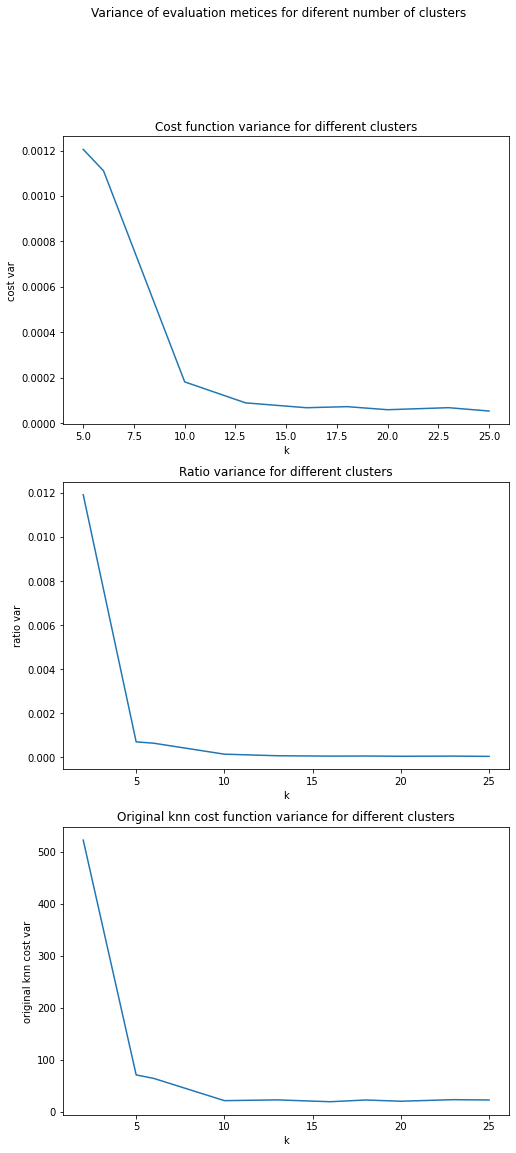

In [ ]:
fig, ax  = plt.subplots(3, 1,figsize=(8,18))

ax[0].plot(all_n_cluster,cost_vars)
ax[0].set_xlabel("k")
ax[0].set_ylabel("cost var")
ax[0].set_title('Cost function variance for different clusters')

ax[1].plot(all_n_cluster,ratio_vars)
ax[1].set_xlabel("k")
ax[1].set_ylabel("ratio var")
ax[1].set_title('Ratio variance for different clusters')

ax[2].plot(all_n_cluster,cost_k_vars)
ax[2].set_xlabel("k")
ax[2].set_ylabel("original knn cost var")
ax[2].set_title('Original knn cost function variance for different clusters')


fig.suptitle('Variance of evaluation metices for diferent number of clusters');
fig.show()


As we can see the variance in ratio and cost functions decreases as the number of clusters grows. we can also see that the plots behaviour changes for k>5. the absolute value of the plot gradiant decreases sufficiently for k>5.so an elbow shape appears at k=5.

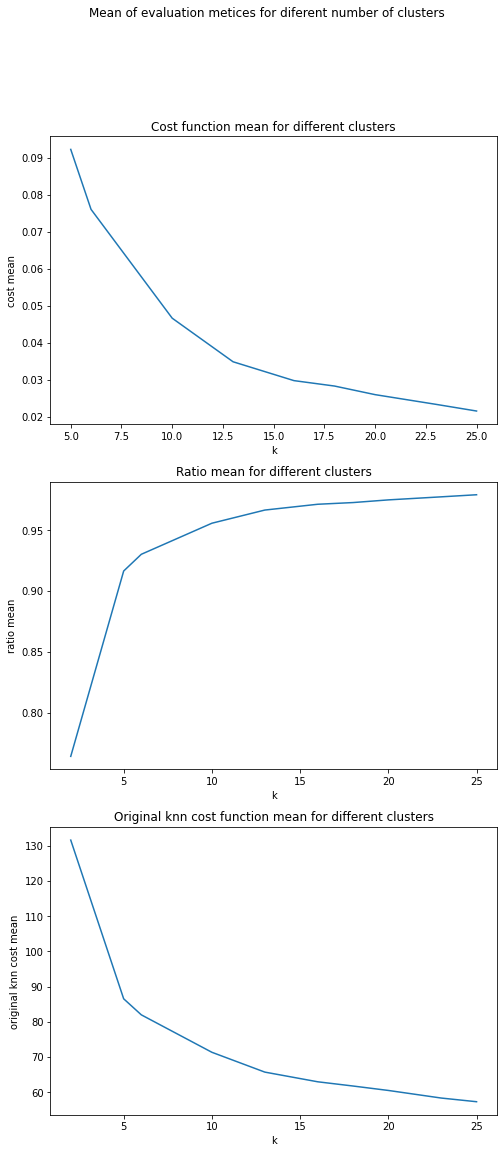

In [ ]:
fig, ax  = plt.subplots(3, 1,figsize=(8,18))

ax[0].plot(all_n_cluster,cost_means)
ax[0].set_xlabel("k")
ax[0].set_ylabel("cost mean")
ax[0].set_title('Cost function mean for different clusters')

ax[1].plot(all_n_cluster,ratio_means)
ax[1].set_xlabel("k")
ax[1].set_ylabel("ratio mean")
ax[1].set_title('Ratio mean for different clusters')

ax[2].plot(all_n_cluster,cost_k_means)
ax[2].set_xlabel("k")
ax[2].set_ylabel("original knn cost mean")
ax[2].set_title('Original knn cost function mean for different clusters')
fig.suptitle('Mean of evaluation metices for diferent number of clusters');
fig.show()


As we can see all the functions behaviour change at point k=5. the cost functions do not decrease a lot for k>5 and the ratio function does not increase a lot for k>5 and an elbow shape appeares at k=5. so for k=5 clusters, the data points within a cluster are close enough and the data points in different clustrs are far enough and by increasing the clusters more than 5, the inter-cluster and the intra-cluster distance doe not chamge much. so k=5 is the best number of clusters

# Constrained Kmeans Clustering

**A)**

In this part we have two kinds of constraints on some of our data points:



*   Must-link constraints which specify that two instances
have to be in the same cluster.
*   Cannot-link constraints which specify that two inastances must not be placed in the same cluster.

The must-link constraints define a transitive binary relation over the instances. Consequently, when making
use of a set of constraints (of both kinds), we take a
transitive closure over the constraints. Although only the must-link constraints are transitive,the closure is performed over both kinds.for example if $d_i$
must link to $d_j$ which cannot link to $d_k$, then we also know
that di cannot link to $d_k$.

We use COP-kmeans algorithm with an adjusment: 

ADJUSTED-COP-KMEANS(data set D,must-link constraints $C_{on=}$, cannot-link constraints $C_{on\neq}$, number of iterations $n_{itr}$ )


1.   Let $C_0,C_1,...,C_{k-1}$ be the initial cluster centroids.

1.   SORT_DATASET

2.   For each data point $x_i$ in $D$, assign it to the colsest cluster $C_J$ such that "VIOLATE-CONSTRAINTS($d_i,C_j,C_{on=},C_{on\neq}$) is false. If no such cluster exists, fail(return{}).

3.   For each cluster $C_j$, update its center by averaging all data points that have been assigned to it.
3.   Iterate between (2) and (3) for $n_{itr}$ times or convergence.

3.   Return $\{C_0, ..., C_{k-1}\}$

VIOLATE-CONSTRAINTS(data set D,must-link constraints $C_{on=}$, cannot-link constraints $C_{on\neq}$):


1.   For each $(x,x_=) \in C_{on=} $: If $x_= \in C $, return True
2.   For each $(x,x_{on\neq}) \in C_{on\neq} $: If $x_{on\neq} \in C $, return True
3.   Otherwise, return False

SORT_DATASET(data set D,cannot-link constraints $C_{on\neq}$):
1.   For each data point $x_i$ count number of points that have cannot-link relation with $x_i$:

  $n_{i_{CL}}$= # $\{(x_i,x_{on\neq}) \in C_{on\neq} \}$

2.  Sort D based on $n_{CL}$ in descending order:

     $D_{sorted}=\{x_{a_0}, ..., x_{a_{k-1}}\}$

     $n_{ai_{CL}} \geq n_{aj_{CL}} \iff j\geq i$
3. return $D_{sorted}$

   

This algorithm without step 2 is vey sensitive to the order of dataset:

$S_{CL}=\{Cl_0,CL_1,...,CL_n-1\}$

$CL_i$: all data points that have cannot-link relation with $x_i$

$n_{cl_i}$: size of $CL_i$ set

$k$: number of clusters

if $k> n_{CL_i}$:there is at least one cluster that does not contain any member of $CL_i$, so assigning $x_i$ will not fail

if $k \le n_{CL_i}$: there is a possibility that all clusters contain at least one member of $CL_i$ and the algorithm fails to assign $x_i$.

If it works on a dataset, by changing the order of the points in that dataset, it might not work. so we added an extra step (SORT-DATASET):

ٍWe sort the data points based on $n_{CL}$ and use that order when we want to assign the data points to the clusters, so that the data points with more constraints are assigned earlier than the points with less constraints, therefore not all clusters are accupied by their cannot-link data points and the algorithm does not fail





**B)**

a function to turn constrain dataframe to 2 list of must-link and cannot-list

In [17]:
def csv_lists(df):
    df_ml=df.loc[df['Relation'] == 1]
    df_cl=df.loc[df['Relation'] == -1]
    df_ml=df_ml.drop(columns='Relation')
    df_cl=df_cl.drop(columns='Relation')
    ml=[]
    cl=[]
    for index, row in df_ml.iterrows():
         m=(row['Index1'], row['Index2'])
         ml.append(m)
    for index, row in df_cl.iterrows():
         c=(row['Index1'], row['Index2'])
         cl.append(c)
    return ml,cl

As said before the must-link constraints are transitive:

$ (a,b): must-link, (b,c):must-link \xrightarrow{} (a,c):must-link$

$ (a,b): must-link, (b,c):cannot-link \xrightarrow{} (a,c):cannot-link$

we define function "transitive_entailment_graph" to find all must-links and cannot-links of each data point. we use DFS(Depth First Search)  algorithm for applying the transitive relations

Depth-first search (DFS) starts at the root node and explores as far as possible along each branch before backtracking.


In [18]:
def dfs(v, graph, visited, component):
        visited[v] = True
        for j in graph[v]:
            if not visited[j]:
                dfs(j, graph, visited, component)
        component.append(v)

In [19]:
def transitive_entailment_graph(ml, cl, dslen):
    ml_graph = {}
    cl_graph = {}
    for i in range(dslen):
        ml_graph[i] = set()
        cl_graph[i] = set()

    for (i, j) in ml:
        ml_graph[i].add(j)
        ml_graph[j].add(i)



    visited = [False] * dslen

    for i in range(dslen):
        if not visited[i]:
            component = []
            dfs(i, ml_graph, visited, component)
            for x1 in component:
                for x2 in component:
                    if x1 != x2:
                        ml_graph[x1].add(x2)
            

    for (i, j) in cl:
        cl_graph[i].add(j)
        cl_graph[j].add(i)
        for y in ml_graph[j]:
            cl_graph[i].add(y)
            cl_graph[y].add(i)
        for x in ml_graph[i]:
            cl_graph[x].add(j)
            cl_graph[j].add(x)
            for y in ml_graph[j]:
                cl_graph[x].add(y)
                cl_graph[y].add(x)
    for i in ml_graph:
        for j in ml_graph[i]:
            if j != i and j in cl_graph[i]:
                raise Exception('inconsistent constraints between %d and %d' %(i,j))

    return ml_graph, cl_graph 

we define a function called "violate_constraints" to check if data point p can be assigned to cluster c

In [20]:
def violate_constraints(is_clustered, data_index, cluster_index , ml, cl):
        # print(is_clustered)
        for i in ml[data_index]:
            if is_clustered[i] != -1 and is_clustered[i] != cluster_index :
                return True

        for i in cl[data_index]:
            if is_clustered[i] != -1 and is_clustered[i] == cluster_index :
                return True
            
        return False


we define a function called "closest_clusters". It gets data point $p$ and the set of $Centroids=[C_0,C_1,...,C_{k-1}]$
then it calculates the distance between each centroid $C_i$ and $p$ and sorts the distances in ascending order:

$[d(C_0,p), d(C_1,p),...,d(C_k-1,p)]\xrightarrow{sort}[d(C_{a_0},p), d(C_{a_1},p),...,d(C_{a_{k-1}},p)]$


then replaces $d(C_{a_i},p)$ with index $a_i$
so the function returns $[a_0, a_1, ..., a_{k-1}]$

In [21]:
def closest_clusters(centers, datapoint):
    dists = dist(datapoint, centers)
    return sorted(range(len(dists)), key=lambda x: dists[x])

we define a function called "assign_datapoint_constrain". for each data point p, it sorts the cluster centers using "closest_clusters" function. 
choose the closest cluster $C_k$, assign p and all its must-links to cluster $C_k$ if it does not violate any constrain. if p can not be in cluster $C_k$, find the next closest cluster untill running out of clusters.



In [22]:
def assign_datapoint_constrain(clusters,x_idx,x,centers,ml,cl):
    indices= closest_clusters(centers, x)
    counter = 0
    if clusters[x_idx] == -1:
        found_cluster = False
        while (not found_cluster) and counter < len(indices):
            c_idx = indices[counter]
            if not violate_constraints(clusters, x_idx, c_idx , ml, cl):
                found_cluster = True
                clusters[x_idx] = c_idx
                for j in ml[x_idx]:
                    clusters[j] = c_idx
                    # print("cluster number"+str(c_idx))
                    # print("x_idx"+str(x_idx))
            counter += 1
        if not found_cluster:
                    print("fail")
                    # print("x_idx"+str(x_idx))
                    return None
    return   clusters         

we define a function called "cluster_idx_data" that turns the clusters list to lists of clusters including datapoints of that cluster

In [23]:
def cluster_idx_data(clusters,x):
    cluster_indices=list(np.sort(np.array(list(set(clusters)))))
    # print(cluster_indices)
    n_cluster=len(cluster_indices)
    # print(n_cluster)
    sorted_points = []
    # cluster_dict = dict.fromkeys(cluster_dict_keys, [])
    for c_idx in cluster_indices:
        indices= [i for i, x in enumerate(clusters) if x == c_idx]
        # print(list(x[indices]))
        sorted_points.append(list(x[indices]))
    return sorted_points

we define "cop_kmeans" function to execute the COP-kmeans algorithm

In [24]:
def cop_kmeans(dataset, ml, cl,n_cluster,max_iter):
    cents = initial_centroid(dataset,n_cluster)
    all_cost=[]
    all_ratio=[]
    all_kmean_cost=[]
    for i in range(max_iter):
        clusters = [-1] * len(dataset)
        for x_idx, x in enumerate(dataset):
            # print("i"+str(x_idx))
            clusters=assign_datapoint_constrain(clusters,x_idx,x,cents,ml,cl)
            ########## all data points are assigned to a cluster
        sorted_points=cluster_idx_data(clusters,dataset)
        prev_cents=cents
        cents=update_centroid(sorted_points,prev_cents)
        all_cost.append(cost(sorted_points))
        all_ratio.append(ratio(sorted_points))
        all_kmean_cost.append(k_means_cost_func(sorted_points,cents))


    return sorted_points,all_cost,all_ratio,all_kmean_cost,cents,clusters

since the initial cluster centroids effects the final clusters, and are chosen randomly, we repeat the algorithm multiple times and calculate the mean and variance of the results(cost functions and the ratio) to have more stable results

In [25]:
def mean_var_cost_cop(n_alg_iter,n_cluster,max_iter,x,ml,cl,y):
    costs=[]
    ratios=[]
    cost_knns=[]
    accuracy=[]
    for i in range(n_alg_iter):
         
         
         _,j,r,k,_,clusters=cop_kmeans(x, ml, cl,n_cluster,max_iter)
         costs.append(j[-1])
         ratios.append(r[-1])
         cost_knns.append(k[-1])
        #  accuracy.append(find_label_cluster(clusters,y,n_cluster))
    
    costs=np.array(costs)
    ratios=np.array(ratios)
    cost_knns=np.array(cost_knns)
    accuracy=np.array(accuracy)

    cost_mean=np.mean(costs)
    ratio_mean=np.mean(ratios)
    cost_knn_mean=np.mean(cost_knns)
    # accuracy_mean=np.mean(accuracy)

    cost_var=np.var(costs)
    ratio_var=np.var(ratios)
    cost_knn_var=np.var(cost_knns)
    # accuracy_var=np.var(accuracy)

    return cost_mean, ratio_mean, cost_knn_mean,  cost_var, ratio_var, cost_knn_var


we define two functions called "accuracy_constraind_cluster" and "accuracy_cluster" to calculate the accuracy of the labels.
for each cluster, we count the number of accurances of all labels, and assign the label the label with maximum accurance, to that cluster. so the number of true labels in that cluster is the maximum accurance of the labels in that cluster.

$a_{i,j}$: number of data points with label $i$ in cluster $j$.

for each cluster $C_t$ we have

$M_t=max \{a_{0,t}, a_{1,t}, ...,a_{l-1,t}\} $: number of coorectly assigned data points in cluster $C_t$

$l_t=argmax \{a_{0,t}, a_{1,t}, ...,a_{l-1,t}\} $: the label assigned to cluster $C_t$

$accuracy=\frac{\sum_{i=0}^{k-1} M_i}{n}$

$n$: size of dataset

$k$: number of clusters = number of classes


In [26]:
def accuracy_constraind_cluster(clusters,y,num_label):
    n_data=len(y)
    cluster_labels=[]
    num_max_label=[]
    clusters=np.array(clusters)
    for c_i in range(num_label):
        cluster_i_idxes = np.where(clusters == c_i)[0]
        cluster_i_label=np.array(list(y[cluster_i_idxes]))
        count_list=[]
        for l_i in range(num_label):
            count_i = (cluster_i_label == l_i).sum()
            count_list.append(count_i)
        # print(count_list)
        cluster_labels.append(np.argmax(np.array(count_list)))
        num_max_label.append(np.max(np.array(count_list)))

    accuracy=np.sum(num_max_label)/n_data
    return accuracy



In [27]:
def accuracy_cluster(sorted_points,y):
    n_data=len(y)
    cluster_labels=[]
    num_max_label=[]

    n_cluster=len(sorted_points)
    n_label=n_cluster
    for i in range(n_cluster):
         label_cluster_i=[]
         for p in sorted_points[i]:
             idx = x.tolist().index(p.tolist())
             label_cluster_i.append(y[idx])
        #  print(label_cluster_i)
         count_list=[]
         label_cluster_i=np.array(label_cluster_i)
         for l_i in range(n_label):
             count_i = (label_cluster_i == l_i).sum()
             count_list.append(count_i)
        #  print(count_list)
         cluster_labels.append(np.argmax(np.array(count_list)))
         num_max_label.append(np.max(np.array(count_list)))
    accuracy=np.sum(num_max_label)/n_data
    return accuracy
   
    

In [28]:
def max_ncl(cl_graph):
    dslen=len(cl_graph)
    n_cl=[]
    for i in range(dslen):
       n_cl.append(len(cl_graph[i]))
    return max(n_cl)

In [29]:
def map_ncl(cl_graph,x,y,df):
    dslen=len(cl_graph)
    n_cl=[]
    for i in range(dslen):
       n_cl.append(len(cl_graph[i]))
    idxes=sorted(range(len(n_cl)), key=lambda j: n_cl[j], reverse=True)
    n_cl.sort(reverse=True)
    x_sort = np.array([x[i] for i in idxes])
    y_sort = np.array([y[i] for i in idxes]) 

    original_idx=list(idxes)
    new_order=list(np.arange(len(original_idx)))
    mapping = dict(zip(original_idx, new_order)) 

    df_new=df.replace({"Index1": mapping,"Index2": mapping})
    ml_new,cl_new=csv_lists(df_new)
    ml_graph_new, cl_graph_new=transitive_entailment_graph(ml_new, cl_new, dslen)

    return x_sort, y_sort ,mapping, df_new, ml_graph_new, cl_graph_new

**C.1)**

In [30]:
df = pd.read_csv('/content/Constraint.txt',delimiter="\t")
dslen=len(x)


In [ ]:
n_sample=[20,40,60]
n_cluster=[5,10,20]
max_iter=50
n_alg_itr=10
result_sample=[]

for n_s in n_sample:
    np.random.seed(n_s)
    d=df.sample(n = n_s)
    ml,cl=csv_lists(df)
    accur=[]
    ml_graph, cl_graph=transitive_entailment_graph(ml, cl, dslen)
    x_sort, y_sort ,mapping, df_new, ml_graph_new, cl_graph_new = map_ncl(cl_graph,x,y,d)
    result_cluster=[]
    for i in range(len(n_cluster)):
        np.random.seed(i)
        c_m, r_m, c_k_m,  _, _, _=mean_var_cost_cop(n_alg_itr,n_cluster[i],max_iter,x_sort
                                                    ,ml_graph_new,cl_graph_new,y_sort)
        result_cluster.append([c_m, r_m, c_k_m])
    result_sample.append(result_cluster)


result_cluster_simple=[]
for i in range(len(n_cluster)):
        np.random.seed(i)
        c_m, r_m, c_k_m, _, _, _=mean_var_cost(n_alg_itr,n_cluster[i],max_iter,x)
        result_cluster_simple.append([c_m, r_m, c_k_m])

In [61]:
results_all=np.zeros((4,3,3))
results_all[0,:,:]=np.array(result_cluster_simple)
results_all[1:4,:,:]=np.array(result_sample)
#sample,cluster,evaluation
n_sample=[0,20,40,60]

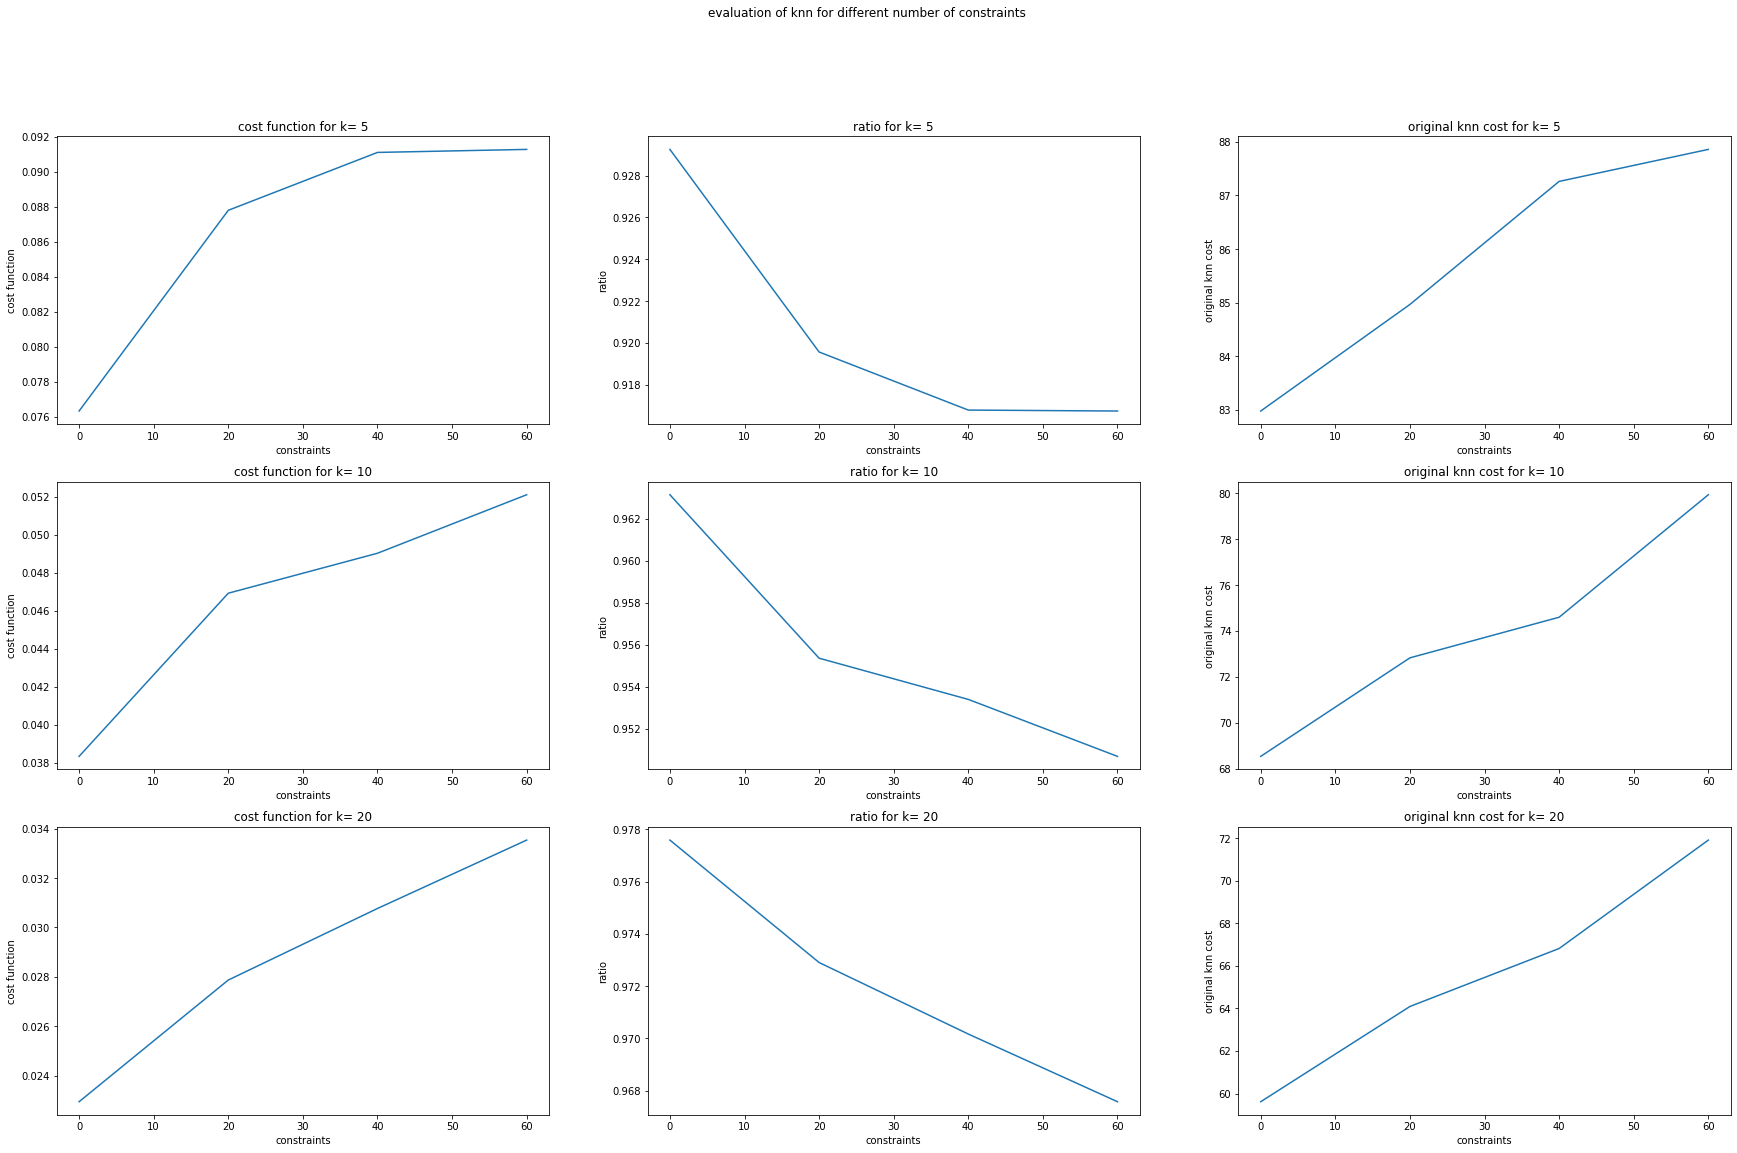

In [71]:
evals=["cost function", "ratio", "original knn cost"]
n_cluster=[5,10,20]
fig, axs = plt.subplots(3, 3,figsize=(30, 18))
# fig.size(18, 10)
for i in range(len(n_cluster)):
    for j in range(3):
        axs[i][j].plot(n_sample, results_all[:,i,j])
        axs[i][j].set_title(evals[j]+" for k= "+str(n_cluster[i]))
        axs[i][j].set_xlabel('constraints')
        axs[i][j].set_ylabel(evals[j])
    # axs[i].set_ylim([0.05,0.3])
fig.suptitle('evaluation of knn for different number of constraints');

We can see that for all number of clusters,as the number of constrains increases, ratio decreases and both cost functions increase. We used the same random seed and run the algorithms multiple times so that the initial centroids does not effect the results, therefore we assume that for each number of cluster, all algorithms with different number of constraints have the same initial centroids.

We get $D_{i,j}=\{ d_{a_0,i,j},d_{a_1,i,j},...,d_{a_{k-1},i,j}\}$ an ordered set containing distance of $x_i$ and all centroids in the algorithm with $j$ constraints.In simple kmeans, the selected centroid is always $c_{a_0}$ and the distance between $x_i$ and selected centroid is always $min(D_{i,0})$. When we add must-link and cannot-link constraints, in each iteration of the algorithm, some data points are forced into a specific cluster(must-link constraint) and some data points are forced to change their selected cluster(cannot-link constraints) so if $x_i$ is assigned to cluster with centroid $c_{a_t}$, $dist(x_i,c_{a_t}) \geq min(D_{i,0})$, also as the number of constraints increases more data points are assigned to furthur clusters, so the  inter-cluster distance increases and the intra-cluster distance decrease. In each algorithm, cost function converges to its minimum value, but the minimum value increases as the number of constraints increases.

**C.2)**

since the initial centroids are random, we run both simple kmeans and constrained kmeans algorithms multiple(10) times and get the mean of results to have more stable results.

In [157]:
df = pd.read_csv('/content/Constraint.txt',delimiter="\t")
dslen=len(x)

In [ ]:
n_sample=[20,40,60]
n_cluster=3
max_iter=50
n_alg_itr=10
accuracy_mean=[]
accur_simp=[]
for n_s in n_sample:
    np.random.seed(n_s)
    d=df.sample(n = n_s)
    ml,cl=csv_lists(df)
    accur=[]
    ml_graph, cl_graph=transitive_entailment_graph(ml, cl, dslen)
    x_sort, y_sort ,mapping, df_new, ml_graph_new, cl_graph_new = map_ncl(cl_graph,x,y,d)
    for i in range(n_alg_itr):
        np.random.seed(i)
        _,_,_,_,_,clusters=cop_kmeans(x_sort, ml_graph_new, cl_graph_new,n_cluster,max_iter)
        ac=accuracy_constraind_cluster(clusters,y_sort,n_cluster)
        accur.append(ac)
    accur=np.array(accur)
    accuracy_mean.append(np.mean(accur))


for i in range(n_alg_itr):
        np.random.seed(i)
        sorted_points,_,_,_,_=k_means(n_cluster,x,max_iter)
        ac=accuracy_cluster(sorted_points,y)
        accur_simp.append(ac)
accur_simp=np.array(accur_simp)
accuracy_mean.insert(0, np.mean(accur_simp))
n_sample.insert(0,0)

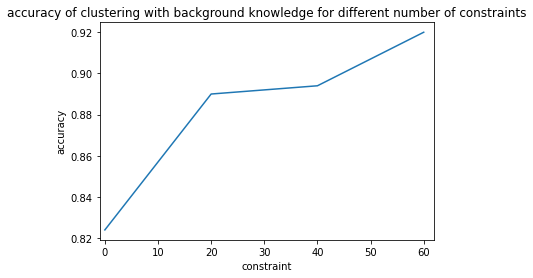

In [155]:

plt.plot(n_sample, accuracy_mean)
plt.xlabel('constraint')
plt.ylabel('accuracy')
plt.title('accuracy of clustering with background knowledge for different number of constraints')
plt.xlim([-1,62]);
plt.show()

We can see that simple kmeans algorithm(number of constraints=0) has the least accuracy and as the number of constraints increases, the accuracy also increases.by using the must-link and cannot link constraints from our background knowledge,the clusters are forced to become more like the actual labels, so when we use a supervised evaluation methode, the results improve as we use more knowledge from the ground truth.

Overall we can say that using constraints improves the supervised clustering evaluation parameters such as accuracy, becouse we use the information based on the gorund truth and evaluate the algorithm using the true labels, but it worsens the cost functions based on inner and outer distance becouse it forces some datapoints not to be assigned to the cluster with the nearest distance.